In [1]:
import numpy as np
import matplotlib.pyplot as plt
from LJhelpers import *

### 3. Lennard-Jones Pair Potentials

In [2]:
# Four local minima of LJ7:
# f1 = -16.50538417 Pentagonal bipyramid
# f2 = -15.93504306 Capped octahedron
# f3 = -15.59321094 Tricapped tetrahedron
# f4 = -15.53306005 Bicapped trigonal bipyramid

Na = 7 # number of atoms
rstar = 2**(1 / 6) # minimizer of Lennard-Jones pair potential r^(-12) - r^(-6)
tol = 1e-9 # stop iterations when ||grad f|| < tol
iter_max = 1000 # maximal number of iterations

# Parameters for backtracking line search
c = 0.1
rho = 0.9

# Options: model = 0, 1, 2, 3, or 4.
# Model 0 corresponds to a random initialization.
# Models 1--4 set the system up close to the corresponding local minima
# listed above.
model = 0

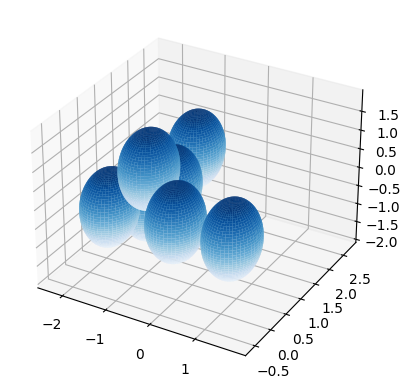

LJpot = -7.225807773709815


In [3]:
xyz = initial_configuration(model, Na, rstar)
x = remove_rotations_translations(xyz)
drawconf(LJvector2array(x), 0.5 * rstar)
print(f'LJpot = {LJpot(x)}')

In [4]:
# start minimization
# choose algorithm
# direction = 0: steepest descent
# direction = 1: Newton
# direction = 2: BFGS
direction = 2

f = LJpot(x)
g = LJgrad(x)
norm_g = np.linalg.norm(g)
print(f'Initially, f = {f}, ||grad f|| = {norm_g}')

fvals = [f]
ngvals = [norm_g]

iter = 1
while (norm_g > tol and iter < iter_max):
    # first choose search direction
    if (direction == 0): # steepest descent
        p = -g
        dir = 'SD'
    elif (direction == 1): # Newton
        H = LJhess(x)
        p = np.linalg.solve(H, -g)
        spd = np.all(np.linalg.eigvals(H) > 0)
        if spd: # if H is SPD, use Newton's direction
            p = np.linalg.solve(H, -g)
            dir = 'Newton'
        else: # use steepest descent direction otherwise
            p = -g
            dir = 'SD'
    elif (direction == 2): # BFGS
        m = 20
        if (iter % m == 1): # reset B to the identity every mth iteration
            B = np.eye(len(x))
        else:
            s = x - x_old
            y = g - g_old
            B = B - (B @ np.outer(s, s) @ B) / np.inner(s, B @ s) + np.outer(y, y) / np.inner(y, s)
        x_old = x
        g_old = g
        p = np.linalg.solve(B, -g)
        dir = 'BFGS'
    else:
        print('direction is out of range')
        break

    # normalize the search direction if its length greater than 1
    norm_p = np.linalg.norm(p)
    if (norm_p > 1):
        p = p / norm_p

    # then do backtracking line search along the direction p
    a = 1 # initial step length
    f_temp = LJpot(x + a * p)
    cpg = c * np.dot(p, g)
    while (f_temp > f + a * cpg): # check Wolfe's condition 1
        a = a * rho
        if (a < 1e-14):
            print('line search failed')
            iter = iter_max - 1
            break
        f_temp = LJpot(x + a * p)

    # finally update values before finishing iteration
    x = x + a * p
    f = LJpot(x)
    g = LJgrad(x)
    norm_g = np.linalg.norm(g)
    print(f'iter {iter}: dir = {dir}, f = {f:.6f}, ||grad f|| = {norm_g:.6e}, step length = {a:.3e}')

    fvals.append(f)
    ngvals.append(norm_g)
    iter = iter + 1
print(f'Result: f = {f:.10f}, ||grad f|| = {norm_g:.6e}')

Initially, f = -7.225807773709815, ||grad f|| = 9.225864624389931
iter 1: dir = BFGS, f = -7.857203, ||grad f|| = 3.443536e+01, step length = 2.824e-01
iter 2: dir = BFGS, f = -8.009597, ||grad f|| = 3.574393e+01, step length = 1.501e-01
iter 3: dir = BFGS, f = -8.049305, ||grad f|| = 3.123720e+01, step length = 4.710e-02
iter 4: dir = BFGS, f = -8.107970, ||grad f|| = 3.185728e+01, step length = 1.094e-01
iter 5: dir = BFGS, f = -8.550051, ||grad f|| = 3.048709e+01, step length = 4.783e-01
iter 6: dir = BFGS, f = -8.697445, ||grad f|| = 2.889391e+01, step length = 1.501e-01
iter 7: dir = BFGS, f = -8.914108, ||grad f|| = 2.897007e+01, step length = 1.501e-01
iter 8: dir = BFGS, f = -9.473672, ||grad f|| = 1.751296e+01, step length = 4.783e-01
iter 9: dir = BFGS, f = -9.758994, ||grad f|| = 9.271987e+00, step length = 2.288e-01
iter 10: dir = BFGS, f = -9.887666, ||grad f|| = 8.158802e+00, step length = 3.138e-01
iter 11: dir = BFGS, f = -9.954014, ||grad f|| = 9.074902e+00, step lengt

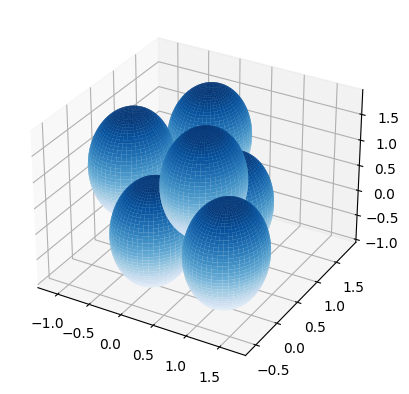

In [5]:
# visualize the final configuration and plot graphs
drawconf(LJvector2array(x), 0.5 * rstar)

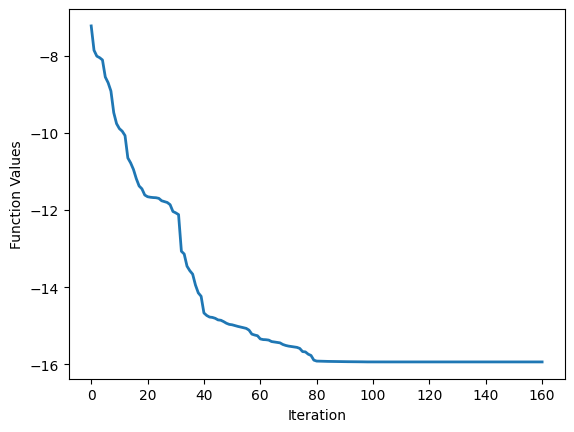

In [6]:
plt.plot(np.arange(iter), fvals, linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Function Values')
plt.show()

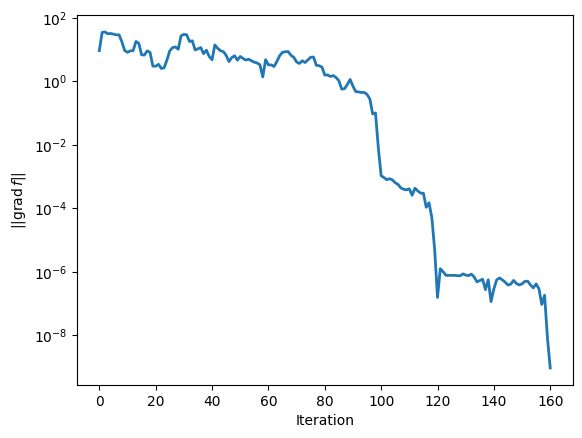

In [7]:
plt.plot(np.arange(iter), ngvals, linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('$|| \operatorname{grad} f ||$')
plt.yscale('log')
plt.show()

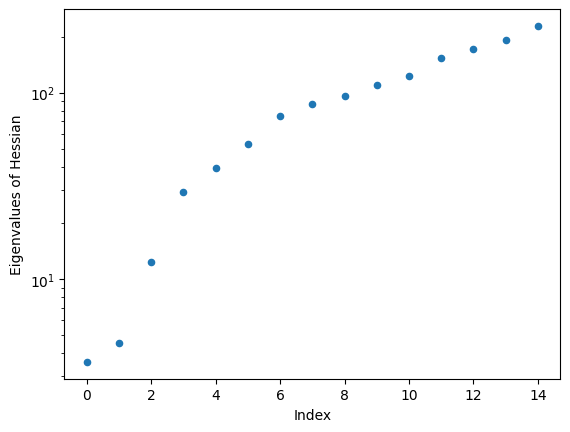

In [8]:
H = LJhess(x)
evals = np.sort(np.linalg.eigvals(H))
plt.scatter(np.arange(np.size(x)), evals, s=20)
plt.xlabel('Index')
plt.ylabel('Eigenvalues of Hessian')
if (evals[0] > 0):
    plt.yscale('log')
plt.show()

### 4. Rosenbrock Function

In [9]:
def rosen_pot(x):
  return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

def rosen_grad(x):
  return np.array([-400 * x[0] * (x[1] - x[0]**2) - 2 * (1 - x[0]), 200 * (x[1] - x[0]**2)])

def rosen_hess(x):
  return np.array([[-400 * (x[1] - x[0]**2) + 800 * x[0]**2 + 2, -400 * x[0]],
                   [-400 * x[0], 200]])

In [10]:
def backtracking_line_search(initial, alpha, method, pot, grad, hess):
  return